### Introduction: Applying Computational Thinking to Personal Finance and Portfolio Analysis
In an era where financial independence is closely tied to the ability to make strategic investment decisions, understanding the mechanics of saving and investing has become a critical life skill. Yet, while many individuals understand the importance of saving, few have the tools or knowledge required to evaluate how different financial strategies—and especially investment decisions—impact long-term outcomes. This tutorial addresses that gap by introducing students to essential concepts in personal finance and portfolio analysis through a computational and data-driven approach.

This tutorial begins by building a foundation in core savings principles. Learners will explore the functionality of common financial instruments such as high-yield savings accounts, 401(k)s, and Roth IRAs. Through interactive inputs and simulations, students will see how interest rates, compound growth, and tax advantages affect returns over time. These early exercises aim to demonstrate the value of starting early, contributing consistently, and choosing the right savings vehicles for one’s personal financial goals.

Building on this foundation, the tutorial then transitions into a more advanced, investment-focused module: constructing and evaluating a personalized stock portfolio. Students will be guided through the process of:
- Selecting their own breakdown of stocks to form a diversified portfolio based on individual risk preferences or interests.

- Evaluating the strength of their chosen portfolio using historical data and key financial metrics.

- Simulating potential future outcomes through Monte Carlo simulations, which model thousands of possible future scenarios to account for uncertainty and market volatility.

- Optimizing the stock allocation using algorithmic methods that balance return potential with risk, aiming for the most efficient use of investment capital.

- Rechecking the portfolio’s strength after optimization, to reflect the improvements made and demonstrate the impact of computational adjustments on financial performance.


Throughout this tutorial, students will employ principles from computer science—such as data modeling, simulations, algorithmic thinking, and data visualization—to analyze financial data and make informed decisions. By the end of the tutorial, students will have developed not only a deeper understanding of financial literacy but also a practical appreciation for how computational tools can empower individuals to manage their personal wealth more effectively.

This interdisciplinary exploration is designed to equip learners with a strong foundation in both personal finance and applied computation—skills that are increasingly essential in today’s data-rich, financially complex world.

### Disclaimer

**No Guarantee of Accuracy:** While Isabel, Luna, and Nirantheri strive to provide accurate and up-to-date information, they do not guarantee the accuracy, completeness, or reliability of any content. Users should independently verify any information before making financial or investment decisions based on it.


**Investment Risks:** Investing involves inherent risks, including but not limited to market fluctuations, economic uncertainty, geopolitical events, and individual asset performance. Past performance is not indicative of future results, and no content provided implies a guarantee of investment success.

**Limitation of Liability:** Mentions of specific financial products, services, companies, or securities within the content do not constitute endorsements or recommendations. Users are responsible for conducting their own research and due diligence.

**No Liability:** Isabel, Luna, Nirantheri, and their affiliates, partners, or contributors shall not be held liable for any loss, damage, or expense resulting from the use of or reliance on the provided information. All investment decisions made based on this content are the sole responsibility of the user.

**Disclaimer Updates:** This disclaimer is subject to change without notice. Users are responsible for reviewing it periodically to stay informed of any updates.



### using old material : Nirantheri


The code to show the importance of investing vs savings (just draw out each of the ira, 401k, hysa along with no investment to show)
How to use information.md?

### setup

include all packages for setting up (pyfolio, package)

In [77]:
# all libraries

# import pyfolio
import yfinance as yf
import numpy as np
import scipy
import ipywidgets as widgets
import pandas as pd
from scipy.optimize import minimize
from IPython.display import display
import altair as alt

### Choosing stocks for a portfolio: Nirantheri


Apple: 'AAPL'
Costco: 'COST'
Microsoft: 'MSFT'
Google: 'GOOG'
Nvidia: 'NVDA'
Walmart: 'WMT'
AMC Entertainment 'AMC'
S&P 500: '^GSPC'
Dow Jones Industrial: '^DJI'
Nasdaq: '^IXIC'
Vanguard S&P 500 ETF: 'VOO'
Vanguard Total Stock Market Index Fund: 'VSMPX'
Fidelity 500 Index Fund: 'FXAIX'
Gold: 'GLD'

Give them a list of 20-30 common stocks, etfs, and mutual funds (can use checkbox widget)
ipywidgets: 
[checkbox](https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#Checkbox)
[select multiple](https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#SelectMultiple)
ex.
- S&P 500
- Dow
- Nasdaq
- Apple
- Tesla
- Google
- Gold??
- etc

In [71]:
codes = {"Apple": 'AAPL',
        "Costco": 'COST',
        "Microsoft": 'MSFT',
        "Google": 'GOOG',
        "Nvidia": 'NVDA',
        "Walmart": 'WMT',
        "AMC Entertainment": 'AMC',
        "S&P 500": '^GSPC',
        "Dow Jones Industrial": '^DJI',
        "Nasdaq": '^IXIC',
        "Vanguard S&P 500 ETF": 'VOO',
        "Fidelity 500 Index Fund": 'FXAIX',
        "Gold":'GLD'}

codes.keys()


choices = widgets.SelectMultiple(
    options=codes.keys(),
    value=[],
    rows=20,
    description='Stocks',
    disabled=False
)

display(choices)

SelectMultiple(description='Stocks', options=('Apple', 'Costco', 'Microsoft', 'Google', 'Nvidia', 'Walmart', '…

### Picking your own breakdown of stocks : Nirantheri

use another widget, maybe with a slider (tbd)

[setup using the above code chunk](https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20List.html#Tabs)

In [72]:
# get breakdown

# get codes for further down
portfolio = []

for i in range(len(choices.value)):
    portfolio.append(codes[choices.value[i]])
    
# pick distribution

tab_contents = ["Value"] * len(choices.value)
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = choices.value

tab


In [73]:
# matching allocation amounts to stock codes given inputs from above

allocations = {}

for i in range(len(tab.children)):
    allocations[portfolio[i]]=tab.children[i].value



### pulling the yf data: Luna

Assume that the list of stocks will come in as a set of stock codes so you can write a loop to get each of them

In [74]:
#pulled a dictionary of different stocks, keys are tickers? i cant think of a better way to store them because the list is variable so its a bit of an issue

# testList = ['AAPL', 'MSFT', 'GOOG', 'NVDA', '^GSPC', '^DJI', '^IXIC']

testList=portfolio
testString = ' '.join(testList)

tickersPull = yf.Tickers(testString)

#in the dictionary dataframes, each ticker is indexed by its ticker as seen in the testList (auto_adjust accounts for splits and dividends)
dataframes = {}
for x in testList:
    ticker = yf.Ticker(x)
    dataframes[x] = ticker.history(period='1mo', start='2015-01-01', auto_adjust=True)
    # print(dataframes[x])



## Checking the returns with this 

https://blog.mlq.ai/python-for-finance-portfolio-optimization/


In [100]:
initial_portfolio_val = 1e6
all_pos_vals = []


for stock_name in dataframes:
    # grab the dataframe for a single stock
    stock_df = dataframes[stock_name] 
    # create normed return column
    stock_df['Normed Return'] = stock_df['Close'] /stock_df.iloc[0]['Close']

    # use normed return to adjust the percentage of portfolio held
    allocation = float(allocations[stock_name])  # Convert allocation to float
    stock_df['Allocation'] = stock_df['Normed Return']*allocation

    # find value of stock at each date
    stock_df['Position Value'] = stock_df['Allocation']*initial_portfolio_val

    # add to list of all position values
    all_pos_vals.append(stock_df['Position Value'])


# concatenate the list of position values
portfolio_val = pd.concat(all_pos_vals, axis=1)

# set the column names
portfolio_val.columns = portfolio

# add a total portfolio column
portfolio_val['Total'] = portfolio_val.sum(axis=1)

# changing date to column not index
portfolio_val = portfolio_val.reset_index()

# Resample the portfolio_val DataFrame to only include the last date of each month
portfolio_val = portfolio_val.resample('ME', on='Date').last().reset_index()

Now that we've created a projection of how our data has been growing over time, let's see what to expect!

5298507.980008615

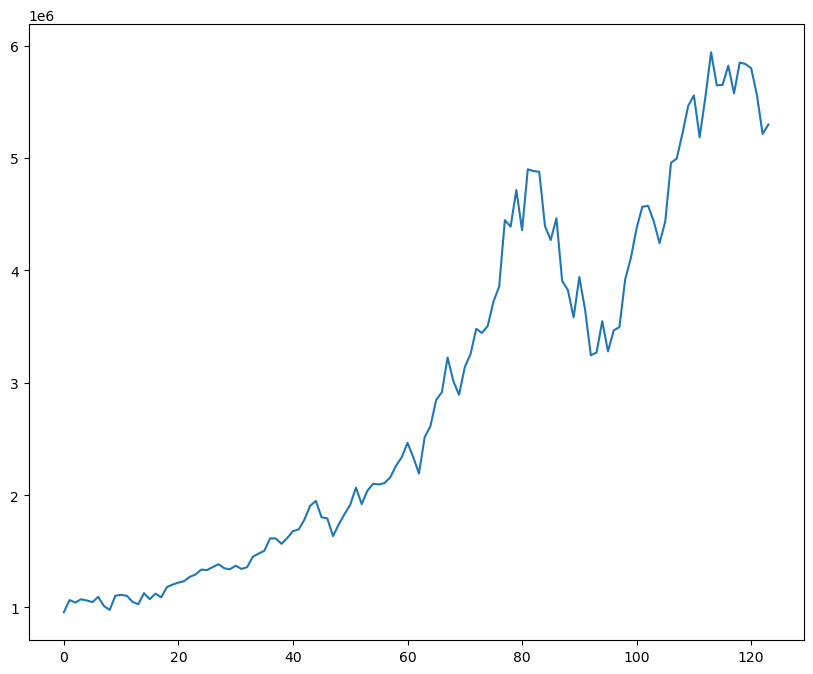

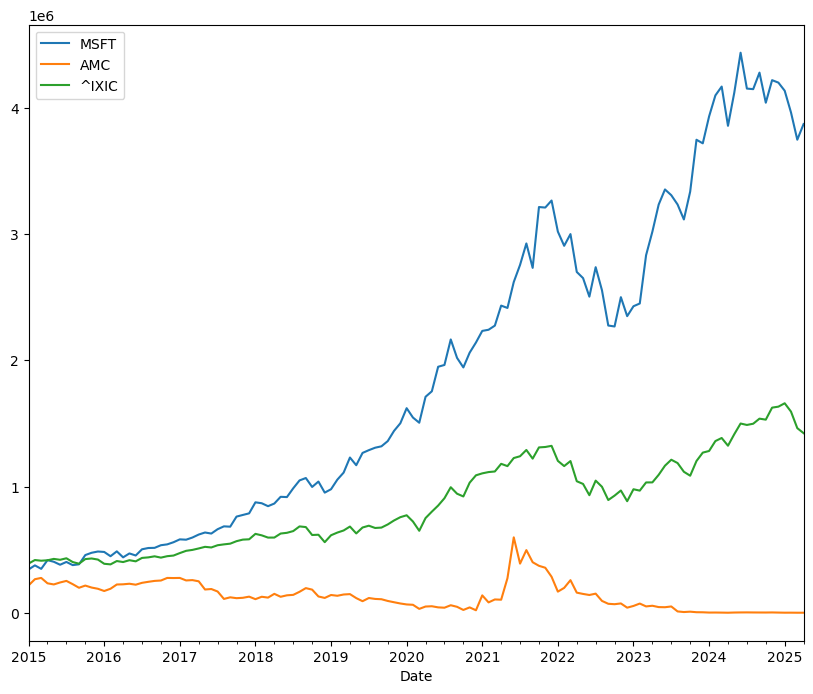

In [ ]:
# # need to pivot the data
# # print(portfolio_val.head())
# print(portfolio_val.info())
# portfolio_val.drop("^IXIC", axis=1)
# pivoted_data = portfolio_val.melt(id_vars="Date", var_name="Stock", value_name="Value")

# pivoted_data.head()


# alt.Chart(pivoted_data).mark_line().encode(
#     alt.X("Date:T", title="Date"),
#     alt.Y("Value:Q", title="Portfolio Value"),
#     alt.Color("Stock:N", title="Stock")
# )


# plot our portfolio
import matplotlib.pyplot as plt
%matplotlib inline
portfolio_val['Total'].plot(figsize=(10,8))
portfolio_val.drop('Total', axis=1).set_index('Date').plot(figsize=(10,8))


print("total value", portfolio_val['Total'].iat[-1])

### check strength of portfolio : Isabel
pyfolio: https://www.pyquantnews.com/the-pyquant-newsletter/create-beautiful-strategy-tear-sheets-pyfolio-reloaded
can also use quantstats



pyfolio: get the tear sheets--> then use pandas to pull specific metrics (annual return, etc) and then have a md cell which breaks down what each of them means

### montecarlo simulations : tbd

uses yahoo finance package and others to create montecarlo simulation for modeling

montecarlo https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

### optimizing the set of stocks : luna

use scipy

optimizing your investment: https://medium.com/@ethan.duong1120/python-powered-portfolio-optimization-achieving-target-returns-through-weight-optimization-fc5163e5c9c6


In [ ]:
testList = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'NFLX', 'SBUX', '^GSPC', '^DJI', '^IXIC']

# pull the first stock's data; drop all unnecessary columns
ticker = yf.Ticker(testList[0])
df = ticker.history(interval = '1d', start = '2015-01-01', end = '2025-04-01')
df.drop(columns=['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.rename({'Open' : 'AAPL'})

# for every other ticker, add its open value to the existing dataframe
for x in testList[1:]:
    ticker = yf.Ticker(x)
    data = ticker.history(interval = '1d', start = '2015-01-01', end = '2025-04-01')
    df.insert(len(df.columns), x, data["Open"]) # for whatever reason, this line wont work

#calculate percent returns for each day of each stock
returns_df = df.pct_change(1).dropna()

#operationalize determining portfolio returns
def getPfReturn(weights):
    """
    return is annualized expected return of portfolio
    """
    expRetPortfolio = np.dot(np.transpose(weights), returns_df.mean()) * 250
    return expRetPortfolio

# start with stocks at equal weights
numStocks = len(returns_df.columns)
initialWeight = [1/numStocks] * numStocks

# return goal?
targetReturn = .4

# bounds the percentage of each stock we can hold (between 0 and 100%)
bounds = tuple((0,1) for i in range(numStocks))

# ensures the sum of all stock weights is 100% (or 1) in first constraint
# sets goal of minimize function to hit targetReturn
constraints = ({'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1},
               {'type' : 'eq', 'fun' : lambda x : x.dot(returns_df.mean()) * 250 - targetReturn})

# can we reach our goal with these stocks??
results = minimize(fun=getPfReturn, x0=initialWeight, bounds=bounds, constraints=constraints)

#output
print(results)

optimizedResults = pd.DataFrame(results['x'])

# print our optimized results
getPfReturn(weights=results["x"])
optimizedResults.index = returns_df.columns
print(optimizedResults)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.4000000002288577
       x: [ 7.368e-02  6.603e-02  2.776e-17  5.137e-01  3.465e-01
            6.939e-17  1.388e-17  0.000e+00  0.000e+00]
     nit: 2
     jac: [ 2.536e-01  2.501e-01  2.124e-01  4.548e-01  3.784e-01
            1.383e-01  1.077e-01  9.317e-02  1.462e-01]
    nfev: 20
    njev: 2
                  0
Open   7.367808e-02
MSFT   6.603353e-02
GOOG   2.775558e-17
TSLA   5.137479e-01
NFLX   3.465405e-01
SBUX   6.938894e-17
^GSPC  1.387779e-17
^DJI   0.000000e+00
^IXIC  0.000000e+00


## Rechecking the Returns

### may need to redo the code above but brainstorming ways to not have to do that using functions

### rechecking the strength of your portfolio : isabel's

go back to pyfolio--> will integrate after we recheck the working code